# Exercise I: Exploratory Data Analysis (EDA)

In our first exercise, we will explore a public dataset of Coronavirus PCR tests based on a fascinating [blog post](https://blog.mafatchallenge.com/2020/04/30/covid-19-testing-with-ml-part-2/) published as part of the [MAFAT Challenge](https://mafatchallenge.mod.gov.il/).

The purpose of this exercise is to demonstrate the importance of inspecting data and understanding it before trying to do anything fancy. As elementary as it may sound, this preliminary step is the pitfall of many data analysis pipelines and nurturing an instinct for visualizing and organizing your raw data will pay off tremendously both in the process of developing and in evaluating the robustness of your models.

We'll start things off by summarizing some key information about the dataset:

* The dataset is shared as [a GitHub repository](https://github.com/mdcollab/covidclinicaldata) containing a directory of CSV files.
* It is collected by two US-based companies providing services in the health industry.
* There are also chest X-rays available for some of the patients, that were not included in this analysis.

So far so good, let's get to work. 

## Data Retrieval

In order to keep things orderly and easy to maintain, we will first create a file with some general configurations:

````{toggle} configuration.py
    :show:
```{literalinclude} configuration.py   
```
````

And then write a short module to create a `read_data()` method:

````{admonition} Technical Note: remove_x_ray_columns
    :class: dropdown, tip
```{literalinclude} read_data.py
    :pyobject: remove_x_ray_columns
```
````

````{toggle}
    :show:
    
```{literalinclude} read_data.py
    :pyobject: read_data
```
````

In [30]:
from read_data import read_data

Now we can read the data by simply running:

In [31]:
data = read_data()

## Raw Inspection

````{admonition} Technical Note: get_scattered_chunks
    :class: dropdown, tip
```{literalinclude} get_scattered_chunks.py
```
````

In [32]:
from get_scattered_chunks import get_scattered_chunks

````{admonition} Technical Note: print_table
    :class: dropdown, tip
We will prepare a function to make the styling of the printed dataframe better suited for our purposes:
```{literalinclude} print_table.py
```
```{tip}
For more information about styling Pandas dataframes, see [the documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html).
```
````

In [33]:
from print_table import print_table

In [34]:
data_chunks = get_scattered_chunks(data, n_chunks=5, chunk_size=3)
print_table(data_chunks)

In [35]:
from configuration import TARGET_COLUMN_NAME
from myst_nb import glue

target = data[TARGET_COLUMN_NAME]
n_positives = target.sum()

glue("n_observations", len(data), display=False)
glue("n_columns", len(data.columns), display=False)
glue("target_column_name", TARGET_COLUMN_NAME, display=False)
glue("n_positives", n_positives, display=False)

Alright! Some things that we can already learn about our dataset from this table are:
* It contains a total of {glue:}`n_observations` observations.
* There are {glue:}`n_columns` columns with mixed data types (numeric and categorical).
* Missing values certainly exist (we can easily spot `nan` entries).
* The subsample raises a strong suspicion that dataset is imbalanced, i.e. when examining our target variable ({glue:}`target_column_name`) it seems there are far more negative observations than positive ones. A quick `sum()` call reveals that indeed only {glue:}`n_positives` of the {glue:}`n_observations` observations are positive.

There are at least two more built-in methods we could use to get a better sense of the information contained within each column are. The first is:

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93995 entries, 0 to 93994
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   test_name                      93995 non-null  object 
 1   swab_type                      93995 non-null  object 
 2   covid19_test_results           93995 non-null  bool   
 3   age                            93995 non-null  int64  
 4   high_risk_exposure_occupation  93826 non-null  object 
 5   high_risk_interactions         69168 non-null  object 
 6   diabetes                       93995 non-null  bool   
 7   chd                            93995 non-null  bool   
 8   htn                            93995 non-null  bool   
 9   cancer                         93995 non-null  bool   
 10  asthma                         93995 non-null  bool   
 11  copd                           93995 non-null  bool   
 12  autoimmune_dis                 93995 non-null 

In [37]:
n_categorial = len(data.select_dtypes(["object", "bool"]).columns) - 1
n_features = len(data.columns) - 1
glue("n_categorical", n_categorial, display=False)
glue("n_features", n_features, display=False)

This simple table allows us to easily infer that:
* Most ({glue:}`n_categorical`/{glue:}`n_features`) of the collected features are categorial (their data type is `object` or `bool`).
* Some features contain relatively few non-null values.

Another useful method we can use is:

In [38]:
data.describe()

age   temperature         pulse           sys           dia  \
count  93995.00000  47542.000000  48279.000000  46523.000000  46523.000000   
mean      39.17569     36.794765     76.933677    123.149045     78.297079   
std       15.03687      0.289229     13.238270     16.113033      9.464313   
min       -3.00000     33.500000     35.000000     50.000000     15.000000   
25%       28.00000     36.650000     68.000000    112.000000     72.000000   
50%       37.00000     36.800000     76.000000    121.000000     78.000000   
75%       50.00000     36.950000     85.000000    132.000000     84.000000   
max       91.00000     39.600000    160.000000    235.000000    150.000000   

                 rr          sats  days_since_symptom_onset  
count  41448.000000  47535.000000              15865.000000  
mean      14.710601     98.238224                  7.063914  
std        1.971628      1.423986                 17.232417  
min        0.000000     55.000000                  1.000000  
25%       13.000000     97.000000                  2.000000  
50%       15.000000     98.000000                  3.000000  
75%       16.000000     99.000000                  7.000000  
max       40.000000    100.000000                300.000000

In [39]:
from print_table import get_table_styles

table_styles = get_table_styles()
data.describe().style.set_table_styles(table_styles).set_properties(
    **{"text-align": 'center'})

This table summarizes the basic properties of each of the numerical columns contained in the dataset and gives a brief overview of the observed variance.

## Missing Values

Handling missing values requires careful judgement. Possible solutions include:
* Removing the entire feature (column) containing the missing values.
* Removing all observations with missing values.
* *Imputation*: "Filling in" missing values with some constant or statistic, such as the mean or the mode. 

There is not one correct method - different circumstances call for different approaches, and often there is still room for debate. However, some useful guidelines are: 
* If a column contains a small number of observations (relative to the size of the dataset) and the dataset is rich enough and offers more features that could be expected to be informative, it might be best to remove it.
* If the dataset is large and the feature in question is crucial for the purposes of our analysis, remove all observations with missing values. 
* Imputation might sound like a good trade-off if there is a good reason to believe some statistic may adequately approximate the missing values, but it is also the subject of many misconceptions and often used poorly.
* There are also ML methods that can safely include missing values (such as decision trees). We will learn when and how these are used later in this course.

Let's first get a better sense of what fraction of the values is missing in each of the relevant columns in our dataset:

````{admonition} Technical Note: calculate_nan_fractions
    :class: dropdown, tip
```{literalinclude} missing_values.py
    :pyobject: calculate_nan_fractions
```
````

In [40]:
from missing_values import calculate_nan_fractions

In [41]:
missing_fractions_df = calculate_nan_fractions(data)
missing_fractions_df.style.format("{:,.2%}")

In [42]:
positives_fraction = "{:,.2%}".format(len(data[target]) / len(data))
mean_positives_null_fraction = "{:,.2%}".format(missing_fractions_df["Positives Fraction"].mean())

glue("mean_positives_null_fraction", mean_positives_null_fraction, display=False)
glue("positives_fraction", positives_fraction, display=False)

This table allows us to see which columns contain a large fraction of missing values, and also shows us that the mean relative fraction of missing values in Coronavirus-positive observations ({glue:}`mean_positives_null_fraction`) isn't far from the general fraction of positives ({glue:}`positives_fraction`). This is a good sign, and while not really proving anything, gives us good reason to believe the the dataset does not include a ["missing not at random"](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random) bias.

In [43]:
from configuration import NAN_FRACTION_THRESHOLD

glue("nan_fraction_threshold", "{:,.2%}".format(NAN_FRACTION_THRESHOLD), display=False)

Now, we will create a simple function to remove all columns with more than {glue:}`nan_fraction_threshold` of missing values as well as any remaining observations which include missing values:

````{admonition} Technical Note: remove_missing_data_columns
    :class: dropdown, tip
```{literalinclude} missing_values.py
    :pyobject: remove_missing_data_columns
```
````

````{toggle}
    :show:
```{literalinclude} missing_values.py
    :pyobject: clean_missing_values
```
````

And run it:

In [44]:
from missing_values import clean_missing_values

In [45]:
data = clean_missing_values(data)

Our dataset is now clean from any missing values and ready for further inspection.

In [46]:
X = data.drop(TARGET_COLUMN_NAME, axis=1)

categorial_features = X.select_dtypes(["object", "bool"])
numerical_featuers = X.select_dtypes(exclude=["object", "bool"])

print("Categorial features:\n" + ", ".join(categorial_features.columns))
print("\nNumerical features:\n" + ", ".join(numerical_featuers.columns))

Categorial features:
test_name, swab_type, high_risk_exposure_occupation, high_risk_interactions, diabetes, chd, htn, cancer, asthma, copd, autoimmune_dis, smoker, labored_respiration, cough, fever, sob, diarrhea, fatigue, headache, loss_of_smell, loss_of_taste, runny_nose, muscle_sore, sore_throat

Numerical features:
age, temperature, pulse, sats


In [47]:
n_features_after = len(data.columns) - 1
n_observations_after = len(data)
target = data[TARGET_COLUMN_NAME]
n_positives_after = target.sum()

glue("n_features_after", n_features_after, display=False)
glue("n_observations_after", n_observations_after, display=False)
glue("n_positives_after", n_positives_after, display=False)

We are left with {glue:}`n_features_after` features and {glue:}`n_observations_after` observations ({glue:}`n_positives_after` of which are positive).

### Feature Correlations

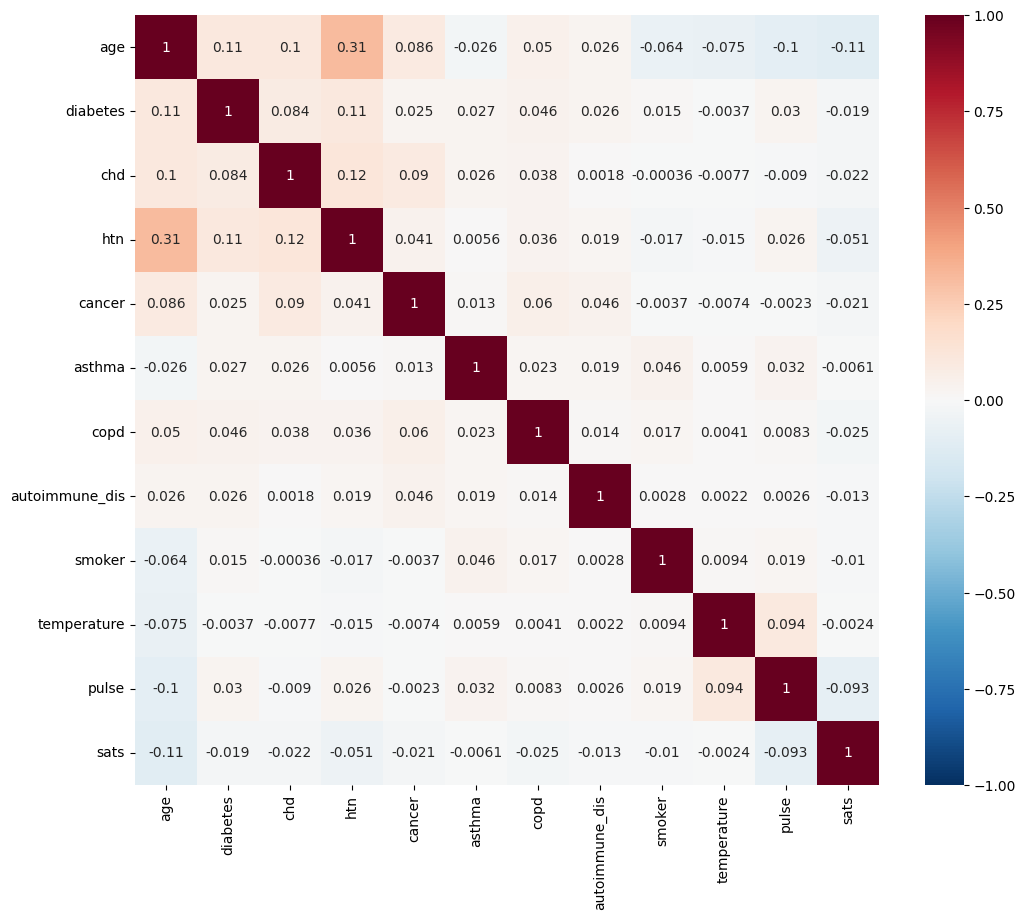

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = X.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
_ = sns.heatmap(correlation_matrix, annot=True,vmin=-1, vmax=1, center=0, cmap="RdBu_r", ax=ax)

## Categorial Features

Boolean columns previously containing missing values might have been originally inferred as `object` type columns, we'll use pandas' `convert_dtypes()` method to infer data types again:

In [49]:
X = X.convert_dtypes()

Assuming $y$ (a COVID-19 positive patient), what is the probability of each of the features (symptomps):

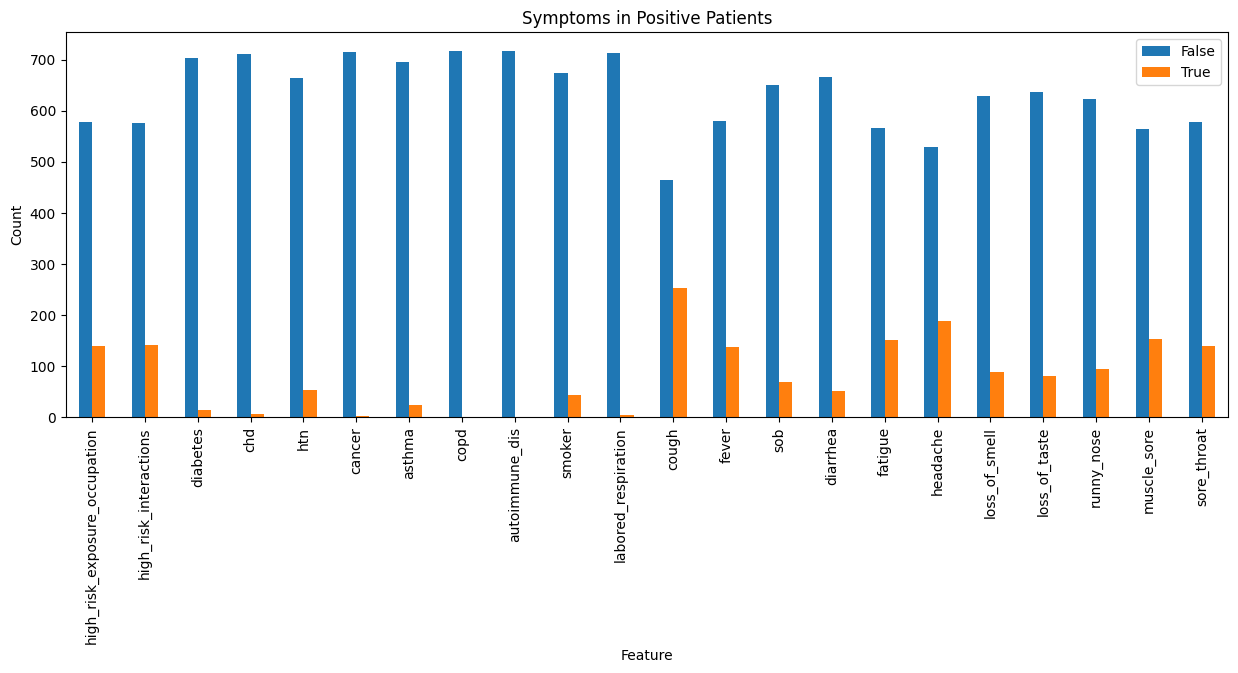

In [50]:
import pandas as pd

boolean_features = X.select_dtypes(["bool"])
positives = boolean_features[target]
value_counts = {}
for column in positives:
    value_counts[column] = positives[column].value_counts()
value_counts = pd.DataFrame(value_counts)

fig, ax = plt.subplots(figsize=(15, 5))
_ = value_counts.T.plot(kind="bar", ax=ax)
_ = plt.title("Symptoms in Positive Patients")
_ = ax.set_xlabel("Feature")
_ = ax.set_ylabel("Count")

To plot the fraction of `True` observations in each of our target groups:

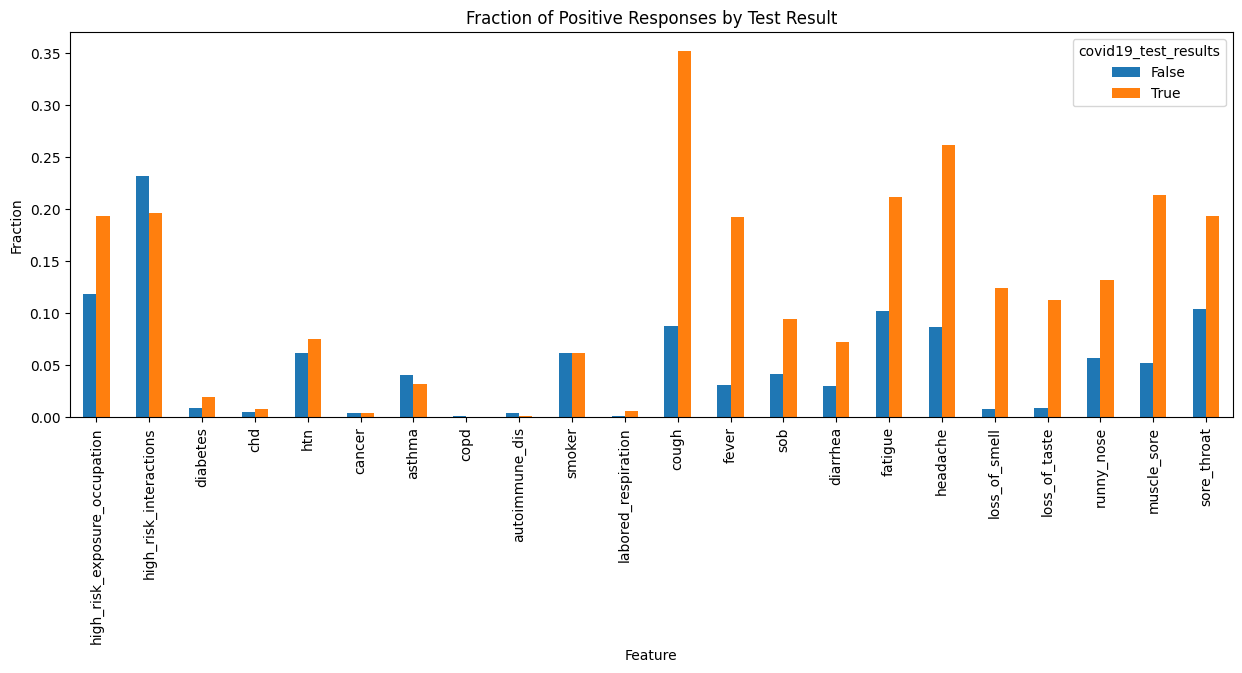

In [51]:
# Group all boolean features by the target variable (COVID-19 test result)
grouped = boolean_features.groupby(target)

# Calculate the fraction of positives in each group.
fractions = grouped.sum() / grouped.count()

# Create a bar plot.
fig, ax = plt.subplots(figsize=(15, 5))
_ = fractions.T.plot(kind="bar", ax=ax)
_ = plt.title("Fraction of Positive Responses by Test Result")
_ = ax.set_xlabel("Feature")
_ = ax.set_ylabel("Fraction")

## Numerical Features

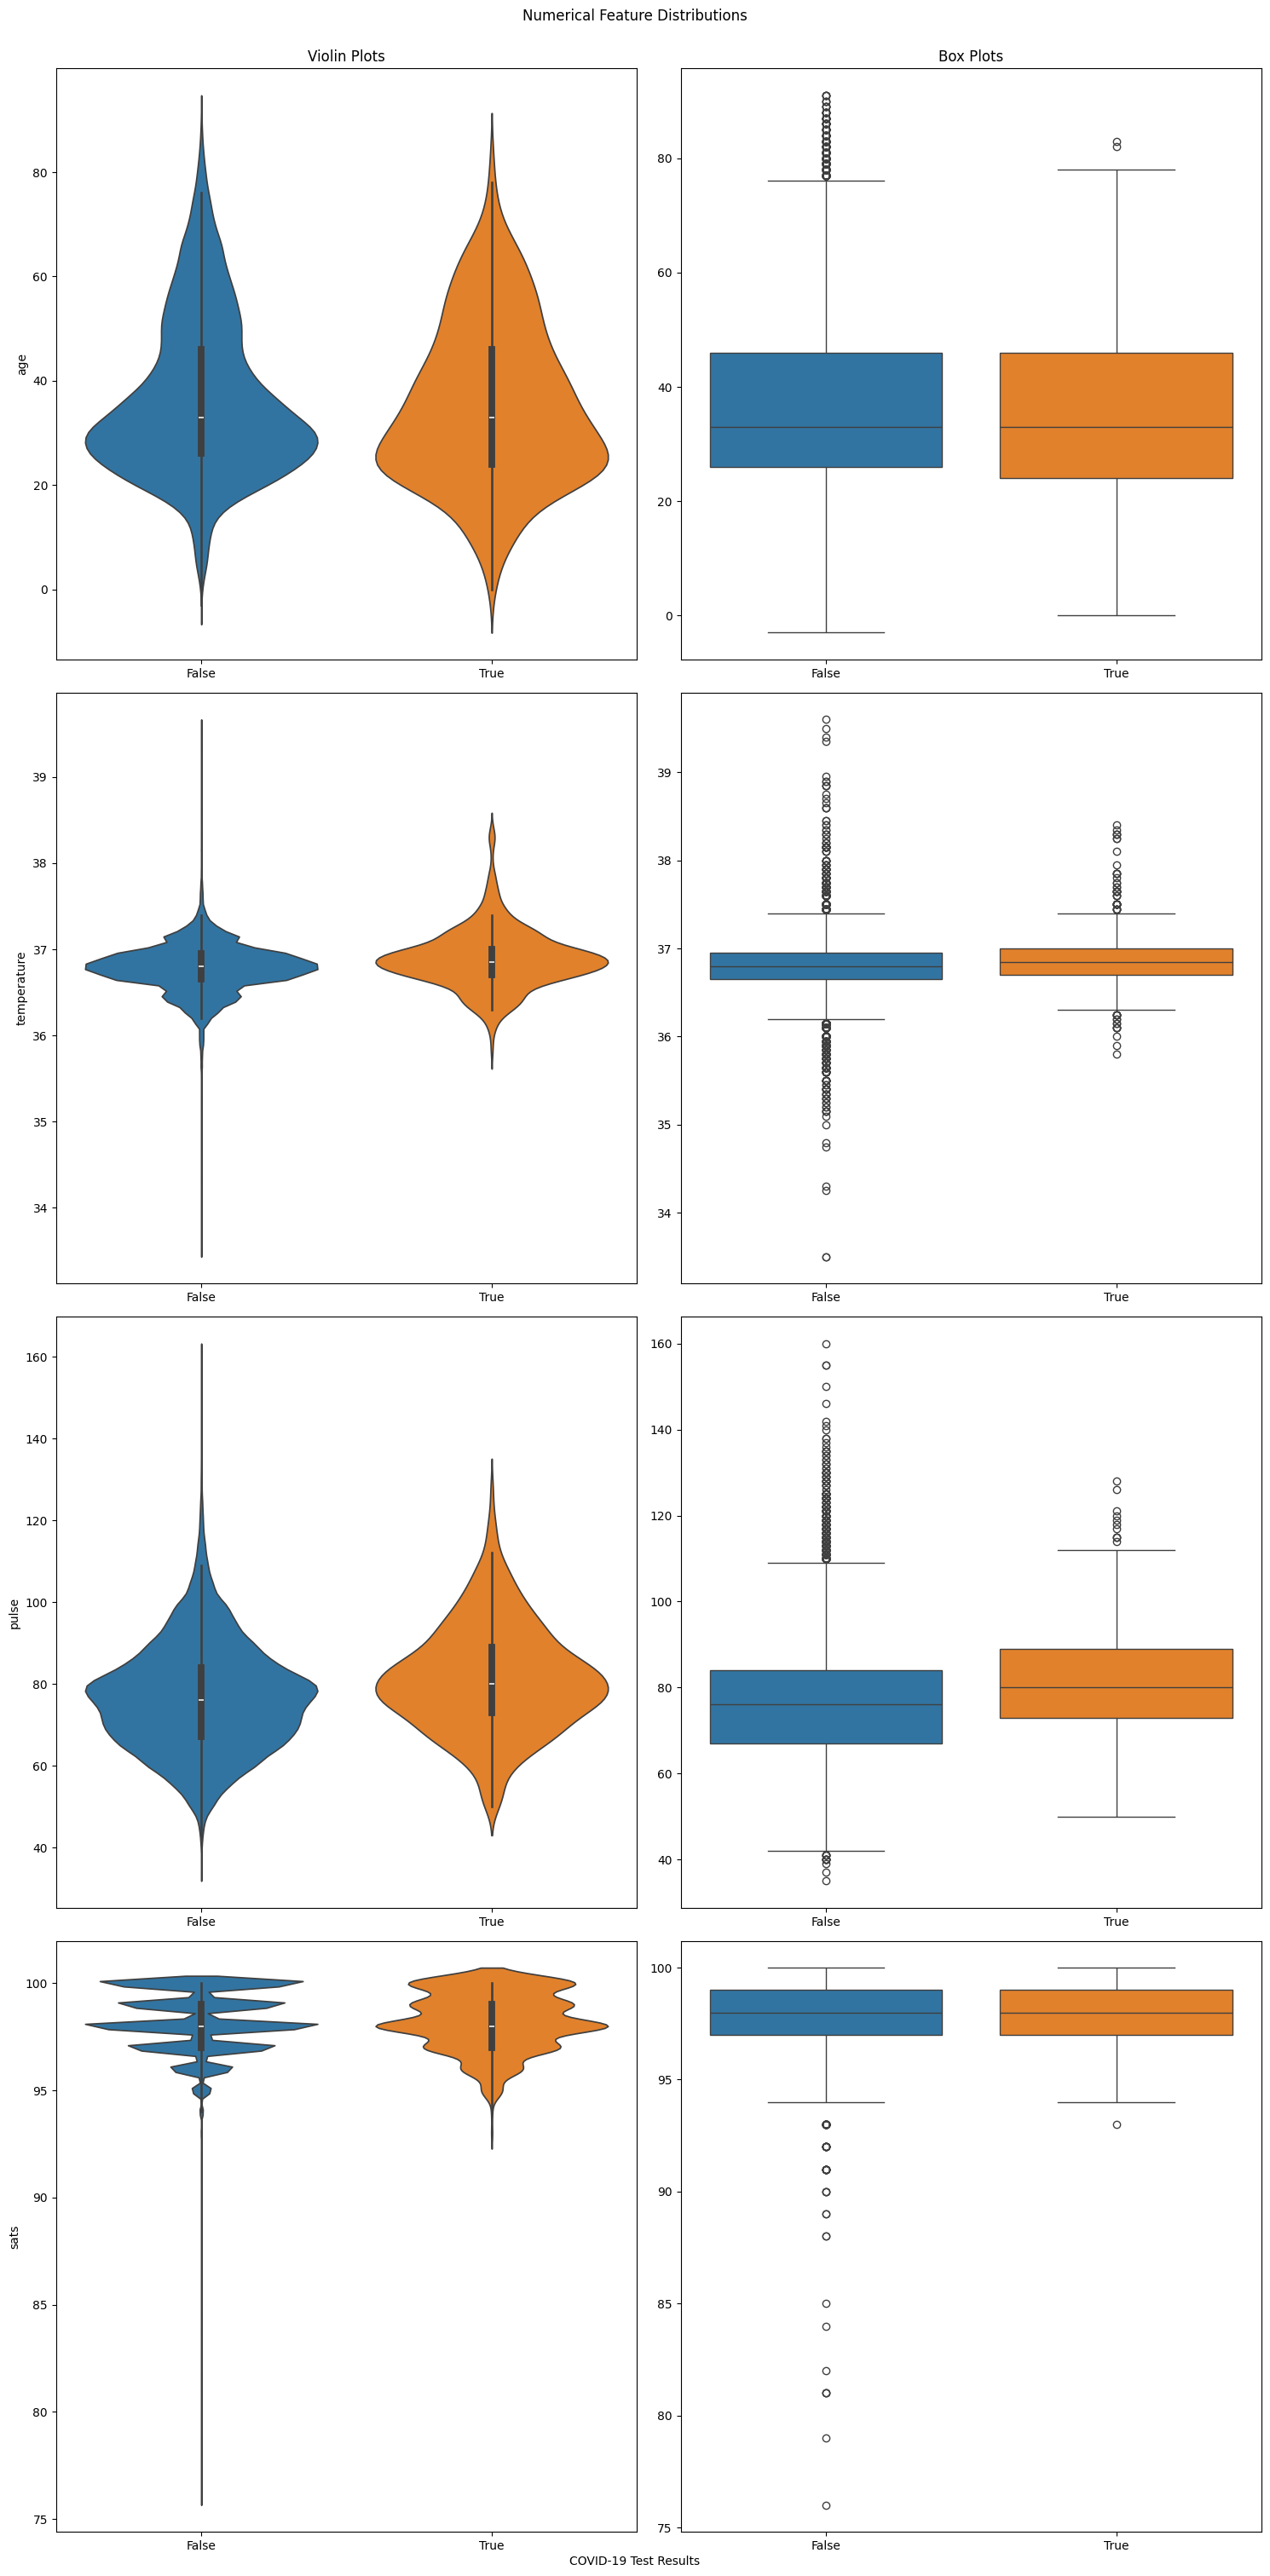

In [52]:
# Select all numerical features.
numerical_features = X.select_dtypes(["float64", "int64"])

# Create distribution plots.
nrows = len(numerical_features.columns)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 30))
for i, feature in enumerate(numerical_features):
    sns.violinplot(x=TARGET_COLUMN_NAME, y=feature, hue=TARGET_COLUMN_NAME, data=data, ax=ax[i, 0], legend=False)
    if i == 0:
        ax[i, 0].set_title("Violin Plots")
        ax[i, 1].set_title("Box Plots")        
    sns.boxplot(x=TARGET_COLUMN_NAME, y=feature, hue=TARGET_COLUMN_NAME, data=data, ax=ax[i, 1], legend=False)
    ax[i, 0].set_xlabel("")
    ax[i, 1].set_xlabel("")
    ax[i, 1].set_ylabel("")
_ = fig.text(0.5, 0, "COVID-19 Test Results", ha='center')
_ = fig.suptitle("Numerical Feature Distributions", y=1)
fig.tight_layout()

```{note}
[Violin plots](https://en.wikipedia.org/wiki/Violin_plot) are essentially [box plots](https://en.wikipedia.org/wiki/Box_plot) combined with a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). While box plots give us a good understanding of the data's quartiles and outliers, violin plots provide us with an informative representation of it's entire distribution.
```